In [28]:
import random
from nltk.tokenize import RegexpTokenizer
import morfeusz
from gensim import corpora, models, similarities, matutils
import numpy as np

def _load_stopwords():
    stopwords = []
    with open('stopwords-pl', 'r') as stopwords_file:
        stopwords = stopwords_file.readlines()
    stopwords = [word.strip() for word in stopwords]
    return set(stopwords)

stopwords = _load_stopwords()


def find_similar(ad_hyperlinks, ads_number):
    dictionary, LSI_model, tf_idf_model, similarity_matrix = _prepare_vector_space_model()
    db = _ads_database.get_ads()
    results = []
    for link in ad_hyperlinks:
        ad_row = db.index.get_loc(link)
        similarities = similarity_matrix.similarity_by_id(ad_row)
        results.append(similarities)

    result = sum(results)
    # negation to sort in descending order
    best_fit = (-result).argsort()[:ads_number]

    best_fit_links = []
    for i in best_fit:
        best_fit_links.append(db.iloc[i])
    return best_fit_links

def _prepare_vector_space_model():
    ads = _ads_database.get_ads()
    ads_data = list(ads['description'])
    ads_data = _tokenize(ads_data)
    ads_data = _to_lowercase(ads_data)
    ads_data = _remove_stopwords(ads_data)
    ads_data = _lemmatize(ads_data)
    dictionary = _prepare_dictionary(ads_data)
    corpus = _prepare_corpus(ads_data, dictionary)
    tf_idf_model = _prepare_tf_idf_model(corpus)
    tf_idf_corpus = _prepare_tf_idf_corpus(corpus, tf_idf_model)
    LSI_model = _prepare_LSI_model(tf_idf_corpus, dictionary)
    similarity_matrix = _prepare_similarity_matrix(LSI_model,
                                                        tf_idf_corpus,
                                                        ads_data)
    return dictionary, LSI_model, tf_idf_model, similarity_matrix


def _tokenize(texts):
    '''Turns documents into alphabetic-only tokens'''
    tokenizer = RegexpTokenizer(r'[a-zA-ZĄąĆćĘęŁłŃńÓóŚśŻżŹź]+')

    result = []
    for text in texts:
        try:
            result.append(tokenizer.tokenize(text))
        except:
            #print(text)
            continue

    return result

def _to_lowercase(texts):
    result = []
    for text in texts:
        result.append([word.lower() for word in text])

    return result

def _remove_stopwords(texts):
    result = []
    for text in texts:
        result.append([word for word in text
                       if word not in stopwords])

    return result

def _lemmatize(texts):
    result = []
    for text in texts:
        text_lemmas = []

        for word in text:
            lemma = morfeusz.analyse(word, expand_tags=False)[0][0][1]
            # morfeusz returns None if has no clue, what the word he got
            if lemma:
                text_lemmas.append(lemma)

        result.append(text_lemmas)

    return result

def _prepare_dictionary(texts):
    return corpora.Dictionary(texts)

def _prepare_corpus(texts, dictionary):
    return [dictionary.doc2bow(text) for text in texts]

def _prepare_tf_idf_model(corpus):
    return models.TfidfModel(corpus)

def _prepare_tf_idf_corpus(corpus, tf_idf_model):
    return tf_idf_model[corpus]

def _prepare_LSI_model(corpus, dictionary):
    return models.LsiModel(corpus, id2word=dictionary,
                           num_topics=30)

def _prepare_similarity_matrix(model, corpus, texts):
    terms = set()
    for text in texts:
        terms |= set(text)
    terms_number = len(terms)

    return similarities.Similarity(output_prefix='sim_matrix',
                                   corpus=model[corpus],
                                   num_features=terms_number)

In [29]:
import fnmatch
import os

offer_filenames =[]

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, 'tagged_offers*pickle'):
        offer_filenames.append(file)

In [30]:
import pickle

offer_batches = []

for offer_batch in offer_filenames:
    with open(offer_batch, 'rb') as offer_batch_pickle:
        offer_batches.append(pickle.load(offer_batch_pickle))

In [31]:
offers = set()

In [32]:
for batch in offer_batches:
    offers |= set(batch.values())

In [33]:
len(offers)

7840

In [34]:
ads_data = list(offers)

In [35]:
ads_data = _tokenize(ads_data)
ads_data = _to_lowercase(ads_data)
ads_data = _remove_stopwords(ads_data)
ads_data = _lemmatize(ads_data)
dictionary = _prepare_dictionary(ads_data) 

In [37]:
terms_number = len(list(dictionary.values()))
dictionary.save('allegro_dictionary')
print("Liczba słów w słowniku modelu: " + str(terms_number))

Liczba słów w słowniku modelu: 10027


In [38]:
corpus = _prepare_corpus(ads_data, dictionary)
tf_idf_model = _prepare_tf_idf_model(corpus)
tf_idf_corpus = _prepare_tf_idf_corpus(corpus, tf_idf_model)

In [39]:
tf_idf_model.save('allegro_tf_idf_model')

In [40]:
import gensim

dense_matrix_corpus = gensim.matutils.corpus2dense(tf_idf_corpus, num_terms=terms_number)

In [41]:
dense_matrix_corpus.shape

(10027, 7840)

In [42]:
s = np.linalg.svd(dense_matrix_corpus, full_matrices=False, compute_uv=False)

In [44]:
len(s)

7840

In [47]:
import matplotlib.pyplot as plt

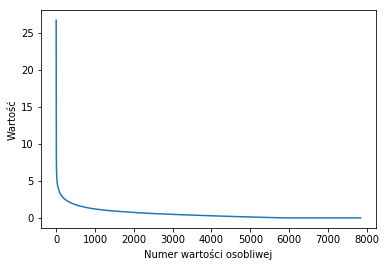

In [49]:
plt.plot(s)
plt.xlabel('Numer wartości osobliwej')
plt.ylabel('Wartość')
plt.draw()

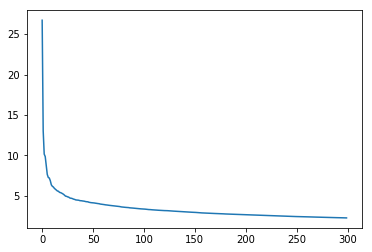

In [48]:
plt.plot(s[:300])

In [178]:
MODEL_TOPICS = 300

In [179]:
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=MODEL_TOPICS)
lsi_model.save('allegro_model_' + str(MODEL_TOPICS) + '_topics')